In [1]:
import statsmodels.api as sm 
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def excel_to_pandas(path):
    """This function converts a csv file into a pandas dataframe. 
    
    Parameters:
        Path: Where the csv file is located on the device
    
    Returns a pandas dataframe.
    """
    New = pd.read_excel(path)
    return New 

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**1. Calling in the combined Yahoo Finance and Google Trends data**

In [2]:
Trends_and_Price = excel_to_pandas('/Users/jacobkuhlman/Desktop/Final Project DA /Google Trends and Price/Trends_and_Price_Year.xlsx')

**2. Extracting just the Ethereum data**

In [3]:
Ethereum_Trends = Trends_and_Price.loc[Trends_and_Price['Cryptocurrency_type'] == 'Ethereum']
Ethereum_Trends = Ethereum_Trends[['Date','Close', 'Search Volume', 'Volume']]
Ethereum_Trends = Ethereum_Trends.set_index('Date')
Ethereum_Trends = Ethereum_Trends.fillna(method = 'pad')

**3. Creating a training and testing set**

In [4]:
n_obs=15

X_training, X_testing = Ethereum_Trends[0:-n_obs], Ethereum_Trends[-n_obs:]
print(X_training.shape, X_testing.shape)

(1753, 3) (15, 3)


**4. Conducting the ADF test**

In [5]:
X_transformed = X_training.diff().dropna() 
transformed_data = X_training.diff().dropna() 

def ADF(is_time_series):
    result = adfuller(is_time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

        
ADF(X_transformed['Close'])
ADF(X_transformed['Search Volume'])

ADF Statistic: -10.884882
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
ADF Statistic: -10.876835
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


**5. Conducting the Granger Causality test**

In [6]:
maxlag = 12
test = 'ssr-chi2test'
def Granger_Causality(X_training, var, test = 'ssr_chi2test', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(var), len(var))), columns=var, index=var) 
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(X_training[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
            
    return dataset
Granger_Causality(Ethereum_Trends, var = Ethereum_Trends.columns)

,Close,Search Volume,Volume
Close,1.0,0.0142,0.0000
Search Volume,0.0,1.0000,0.0218
Volume,0.0,0.0135,1.0000


**6. Conducting the Vector Autoregression model**

In [7]:
mod = VAR(X_transformed)
residual = mod.fit(maxlags=15, ic='aic')

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [8]:
out = durbin_watson(residual.resid)
for col, val in zip(transformed_data.columns, out):
    print((col), ':', round(val,2))

Close : 2.01
Search Volume : 2.0
Volume : 2.0


In [9]:
lag_order = residual.k_ar
input_data = X_transformed.values[-lag_order:]
prediction = residual.forecast(y=input_data, steps=n_obs)
prediction = (pd.DataFrame(prediction, index=X_testing.index, columns=X_testing.columns + '_pred'))

**6a. Combining predicted close prices from the model with the actual close prices**

In [10]:
def transformation(X_training, prediction):
    f = prediction.copy()
    columns = X_training.columns
    for col in columns:
        f[str(col)+'_pred'] = X_training[col].iloc[-1] + f[str(col)+'_pred'].cumsum()
        
    return f
inverted = transformation(X_training, prediction)
Predicted_Actual = pd.concat([inverted['Close_pred'], X_testing['Close']], axis=1)
Predicted_Actual = Predicted_Actual.round(decimals=2)
Predicted_Actual = Predicted_Actual.reset_index()
Predicted_Actual = Predicted_Actual.sort_values(by='Date', ascending=False)

In [11]:
def get_year(df):
    df['Date2'] = df['Date'].str[5:10]
    return df
Predicted_Actual = get_year(Predicted_Actual)
Predicted_Actual = Predicted_Actual.iloc[::-1]

**6c. Plotting the predicted prices vs the actual prices**

//anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
//anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
//anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


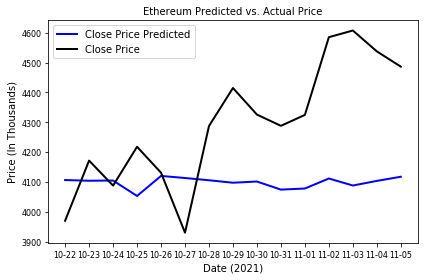

In [12]:
plt.figure(figsize=(6,4))
plt.plot(Predicted_Actual['Date2'], Predicted_Actual['Close_pred'], label = "Close Price Predicted", color = 'Blue', linewidth=2)
plt.plot(Predicted_Actual['Date2'], Predicted_Actual['Close'], label = "Close Price", color = 'Black', linewidth=2)
plt.legend(fontsize=10)
plt.title('Ethereum Predicted vs. Actual Price', fontsize=10)
plt.xlabel("Date (2021)", fontsize=10)
plt.ylabel("Price (In Thousands)",fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('Ethereum_Predicted.png')

In [14]:
from sklearn import preprocessing
Predicted_Copy = Predicted_Actual[['Close_pred', 'Close']]
x = Predicted_Copy.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
Predicted_Normalized = pd.DataFrame(x_scaled)
Predicted_Normalized = Predicted_Normalized.rename(columns={Predicted_Normalized.columns[0]: 'Close_pred'})
Predicted_Normalized = Predicted_Normalized.rename(columns={Predicted_Normalized.columns[1]: 'Close'})

In [16]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
MAE = mean_absolute_error(Predicted_Normalized['Close'], Predicted_Normalized['Close_pred'])
MSE = mean_squared_error(Predicted_Normalized['Close'], Predicted_Normalized['Close_pred'])
MAE
MSE

0.19510394675892995